# Multi-Class Model for Human Activity Recognition Using Scikit-Learn Take 1
### David Lowe
### June 10, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Human Activity Recognition Using Smartphones dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: Researchers collected the datasets from experiments that consist of a group of 30 volunteers, with each person performing six activities by wearing a smartphone on the waist. With its embedded accelerometer and gyroscope, the research captured measurement for the activities of WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING. The dataset has been randomly partitioned into two sets, where 70% of the volunteers were selected for generating the training data and 30% the test data.

In previous iterations, the script focused on evaluating various classic machine learning algorithms and identify the algorithm that produces the best accuracy metric. The previous iterations established a baseline performance in terms of accuracy and processing time.

In this Take1 iteration, we will construct and tune an XGBoost machine learning model for this dataset. We will observe the best accuracy result that we can obtain using the XGBoost model with the training and test datasets.

ANALYSIS: For this Take1 iteration, the XGBoost model achieved an accuracy metric of 99.45% in training. When configured with the optimized parameters, the XGBoost model processed the test dataset with an accuracy of 94.94%, which indicated a high variance issue. We will need to explore regularization techniques or other modeling approaches before deploying the model for production use.

CONCLUSION: For this iteration, the XGBoost algorithm achieved the best overall results using the training and test datasets. For this dataset, Random Forest should be considered for further modeling.

Dataset Used: Human Activity Recognition Using Smartphones

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Task 1. Prepare Environment

In [1]:
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 2.4MB/s 


In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [3]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Jun  7 20:52:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### 1.a) Load libraries and modules

In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import smtplib
from datetime import datetime
from email.message import EmailMessage
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

In [0]:
# Set up the number of CPU cores available for multi-thread processing
# n_jobs = int(ncpu[0])

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 120)
pd.set_option("display.width", 140)

# Set the flag for splitting the dataset
splitDataset = False
# splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

### 1.c) Load dataset

In [9]:
dataset_url = "https://dainesanalytics.com/datasets/ucirvine-human-activity-recognition/"
widthVector = [16] * 561
colNames = ["attr" + str(i).zfill(3) for i in range(1,562)]
X_train_df = pd.read_fwf(dataset_url+'train/X_train.txt', widths=widthVector, header=None, names=colNames)
y_train_df = pd.read_csv(dataset_url+'train/y_train.txt', names=["targetVar"])
Xy_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_test_df = pd.read_fwf(dataset_url+'test/X_test.txt', widths=widthVector, header=None, names=colNames)
y_test_df = pd.read_csv(dataset_url+'test/y_test.txt', names=["targetVar"])
Xy_test_df = pd.concat([X_test_df, y_test_df], axis=1)
Xy_original = pd.concat([Xy_train_df, Xy_test_df], axis=0)

# Take a peek at the dataframe after import
Xy_original.head(10)

attr001   attr002   attr003  ...   attr560   attr561  targetVar
0  0.288585 -0.020294 -0.132905  ...  0.179941 -0.058627          5
1  0.278419 -0.016411 -0.123520  ...  0.180289 -0.054317          5
2  0.279653 -0.019467 -0.113462  ...  0.180637 -0.049118          5
3  0.279174 -0.026201 -0.123283  ...  0.181935 -0.047663          5
4  0.276629 -0.016570 -0.115362  ...  0.185151 -0.043892          5
5  0.277199 -0.010098 -0.105137  ...  0.184823 -0.042126          5
6  0.279454 -0.019641 -0.110022  ...  0.182170 -0.043010          5
7  0.277432 -0.030488 -0.125360  ...  0.183779 -0.041976          5
8  0.277293 -0.021751 -0.120751  ...  0.188982 -0.037364          5
9  0.280586 -0.009960 -0.106065  ...  0.190310 -0.034417          5

[10 rows x 562 columns]

In [10]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Data columns (total 562 columns):
 #   Column     Dtype  
---  ------     -----  
 0   attr001    float64
 1   attr002    float64
 2   attr003    float64
 3   attr004    float64
 4   attr005    float64
 5   attr006    float64
 6   attr007    float64
 7   attr008    float64
 8   attr009    float64
 9   attr010    float64
 10  attr011    float64
 11  attr012    float64
 12  attr013    float64
 13  attr014    float64
 14  attr015    float64
 15  attr016    float64
 16  attr017    float64
 17  attr018    float64
 18  attr019    float64
 19  attr020    float64
 20  attr021    float64
 21  attr022    float64
 22  attr023    float64
 23  attr024    float64
 24  attr025    float64
 25  attr026    float64
 26  attr027    float64
 27  attr028    float64
 28  attr029    float64
 29  attr030    float64
 30  attr031    float64
 31  attr032    float64
 32  attr033    float64
 33  attr034    float64
 34  attr035    float64
 35

In [11]:
Xy_original.describe()

attr001       attr002  ...       attr561     targetVar
count  10299.000000  10299.000000  ...  10299.000000  10299.000000
mean       0.274347     -0.017743  ...     -0.054284      3.624624
std        0.067628      0.037128  ...      0.268898      1.743695
min       -1.000000     -1.000000  ...     -1.000000      1.000000
25%        0.262625     -0.024902  ...     -0.131880      2.000000
50%        0.277174     -0.017162  ...     -0.003882      4.000000
75%        0.288354     -0.010625  ...      0.102970      5.000000
max        1.000000      1.000000  ...      1.000000      6.000000

[8 rows x 562 columns]

In [12]:
Xy_original.isnull().sum()

attr001      0
attr002      0
attr003      0
attr004      0
attr005      0
            ..
attr558      0
attr559      0
attr560      0
attr561      0
targetVar    0
Length: 562, dtype: int64

In [13]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [0]:
# Not applicable for this iteration of the project

### 1.e) Set up the parameters for data visualization

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

## Task 2. Summarize Data

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [17]:
X_train_df.head(10)

attr001   attr002   attr003  ...   attr559   attr560   attr561
0  0.288585 -0.020294 -0.132905  ... -0.841247  0.179941 -0.058627
1  0.278419 -0.016411 -0.123520  ... -0.844788  0.180289 -0.054317
2  0.279653 -0.019467 -0.113462  ... -0.848933  0.180637 -0.049118
3  0.279174 -0.026201 -0.123283  ... -0.848649  0.181935 -0.047663
4  0.276629 -0.016570 -0.115362  ... -0.847865  0.185151 -0.043892
5  0.277199 -0.010098 -0.105137  ... -0.849632  0.184823 -0.042126
6  0.279454 -0.019641 -0.110022  ... -0.852150  0.182170 -0.043010
7  0.277432 -0.030488 -0.125360  ... -0.851017  0.183779 -0.041976
8  0.277293 -0.021751 -0.120751  ... -0.847971  0.188982 -0.037364
9  0.280586 -0.009960 -0.106065  ... -0.848294  0.190310 -0.034417

[10 rows x 561 columns]

#### 2.a.ii) Dimensions and attribute types

In [18]:
X_train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 561 columns):
 #   Column   Dtype  
---  ------   -----  
 0   attr001  float64
 1   attr002  float64
 2   attr003  float64
 3   attr004  float64
 4   attr005  float64
 5   attr006  float64
 6   attr007  float64
 7   attr008  float64
 8   attr009  float64
 9   attr010  float64
 10  attr011  float64
 11  attr012  float64
 12  attr013  float64
 13  attr014  float64
 14  attr015  float64
 15  attr016  float64
 16  attr017  float64
 17  attr018  float64
 18  attr019  float64
 19  attr020  float64
 20  attr021  float64
 21  attr022  float64
 22  attr023  float64
 23  attr024  float64
 24  attr025  float64
 25  attr026  float64
 26  attr027  float64
 27  attr028  float64
 28  attr029  float64
 29  attr030  float64
 30  attr031  float64
 31  attr032  float64
 32  attr033  float64
 33  attr034  float64
 34  attr035  float64
 35  attr036  float64
 36  attr037  float64
 37  attr038  float64
 38  attr039

#### 2.a.iii) Statistical summary of the attributes

In [19]:
X_train_df.describe()

attr001      attr002  ...      attr560      attr561
count  7352.000000  7352.000000  ...  7352.000000  7352.000000
mean      0.274488    -0.017695  ...     0.058593    -0.056515
std       0.070261     0.040811  ...     0.297480     0.279122
min      -1.000000    -1.000000  ...    -1.000000    -1.000000
25%       0.262975    -0.024863  ...    -0.017885    -0.143414
50%       0.277193    -0.017219  ...     0.182071     0.003181
75%       0.288461    -0.010783  ...     0.248353     0.107659
max       1.000000     1.000000  ...     0.478157     1.000000

[8 rows x 561 columns]

#### 2.a.iv) Summarize the levels of the class attribute

In [20]:
Xy_train_df.groupby('targetVar').size()

targetVar
1    1226
2    1073
3     986
4    1286
5    1374
6    1407
dtype: int64

### 2.b) Data Visualization

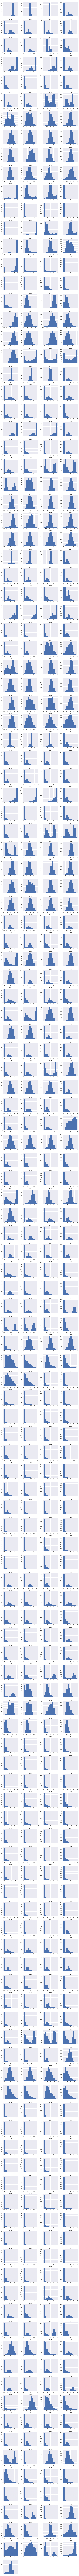

In [21]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

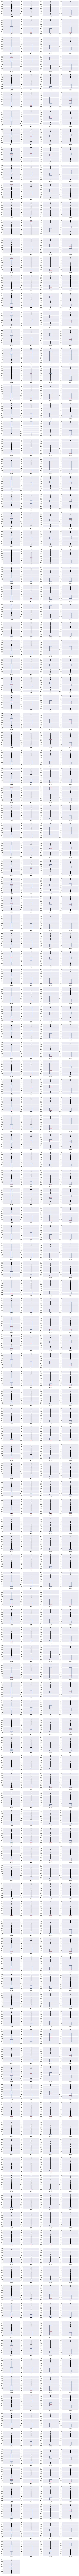

In [22]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

In [0]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_train_df.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

## Task 3. Prepare Data

### 3.a) Splitting Data into Training and Test Sets

In [24]:
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (7352, 561) y_train_df.shape: (7352, 1)
X_test_df.shape: (2947, 561) y_test_df.shape: (2947, 1)


### 3.b) Feature Scaling and Data Pre-Processing

In [0]:
# Not applicable for this iteration of the project

### 3.c) Training Data Balancing

In [0]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [0]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [28]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy().ravel()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy().ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (7352, 561) y_train.shape: (7352,)
X_test.shape: (2947, 561) y_test.shape: (2947,)


## Task 4. Model and Evaluate Algorithms

### 4.a) Set test options and evaluation metric

In [0]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
# train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
# train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
# train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
# train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
train_models.append(('XGB', XGBClassifier(random_state=seedNum, objective='multi:softmax', num_class=6, tree_method='gpu_hist')))

In [30]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.987894 (0.002699)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=6, objective='multi:softmax',
              random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)
Model training time: 0:00:10.067192 

Average metrics (accuracy) from all models: 0.9878943936514102
Total training time for all models: 0:00:10.067936


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.1s finished


### 4.b) Spot-checking baseline algorithms

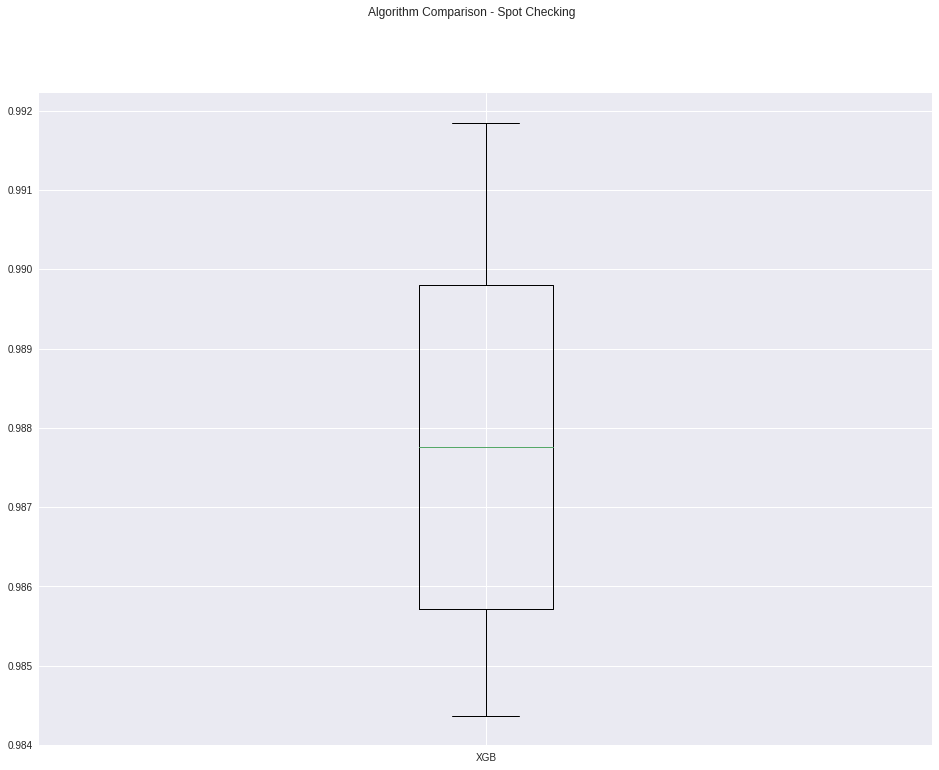

In [31]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Task 5. Improve Accuracy

### 5.a) Algorithm Tuning

In [0]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [33]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight
startTimeModule = datetime.now()
if notifyStatus: email_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=seedNum, objective='multi:softmax', num_class=6, tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100,1001,100), max_depth=np.array([3,6,9]), min_child_weight=np.array([1,2,3]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: email_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, total=   1.8s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=1, n_estimators=100, total=   1.8s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[CV]  max_depth=3, min_child_weight=1, n_estimators=100, total=   1.8s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[CV]  max_depth=3, min_child_weight=1, n_estimators=100, total=   1.8s
[CV] max_depth=3, min_child_weight=1, n_estimators=100 ...............
[CV]  max_depth=3, min_child_weight=1, n_estimators=100, total=   1.8s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[CV]  max_depth=3, min_child_weight=1, n_estimators=200, total=   3.1s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[CV]  max_depth=3, min_child_weight=1, n_estimators=200, total=   3.1s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[CV]  max_depth=3, min_child_weight=1, n_estimators=200, total=   3.1s
[CV] max_depth=3, min_child_weight=1, n_estimators=200 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 54.5min finished


Best: 0.994559 using {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
0.987894 (0.002699) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.992927 (0.001697) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.993879 (0.000746) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.994015 (0.000902) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.994423 (0.000998) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.994559 (0.000744) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
0.994423 (0.000998) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 700}
0.994423 (0.000998) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800}
0.994423 (0.000998) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 900}
0.994559 (0.000744) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000}
0.988846 (0.003293) with: {'max_depth': 3, 'min

### 5.b) Compare Algorithms After Tuning

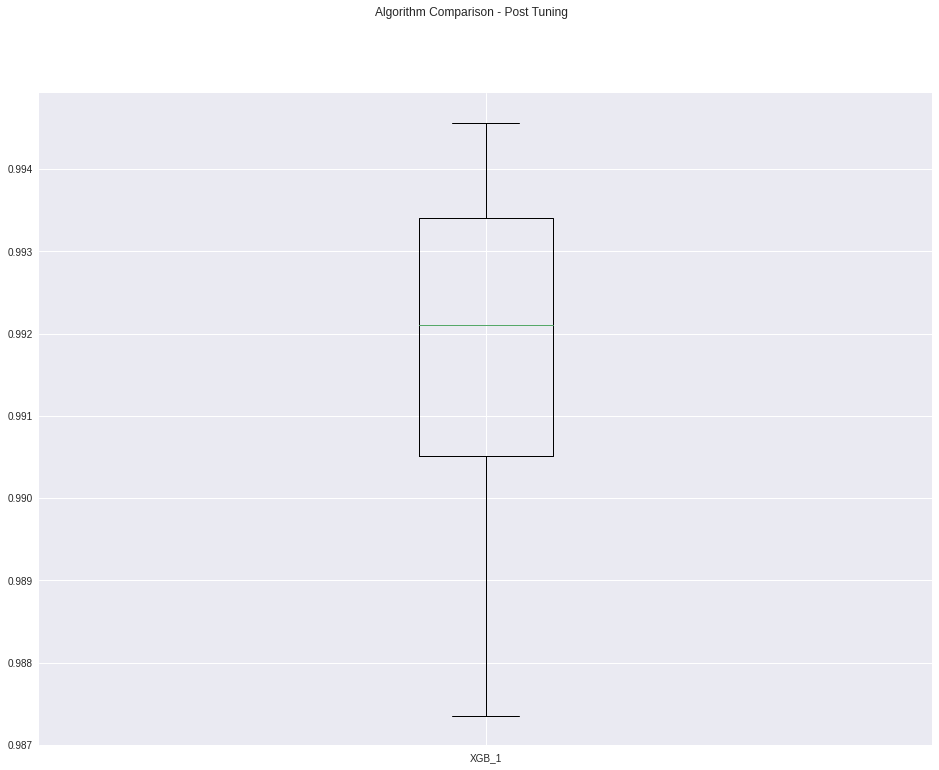

In [34]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Task 6. Finalize Model

### 6.a) Measure predictions from the test dataset

In [35]:
test_model = XGBClassifier(n_estimators=600, max_depth=3, min_child_weight=1, random_state=seedNum, objective='multi:softmax', num_class=6, tree_method='gpu_hist')
test_model.fit(X_train, y_train)
predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(test_model)

Accuracy Score: 0.9494401085850017
[[491   4   1   0   0   0]
 [ 28 437   6   0   0   0]
 [  7  17 396   0   0   0]
 [  0   2   0 429  60   0]
 [  0   0   0  24 508   0]
 [  0   0   0   0   0 537]]
              precision    recall  f1-score   support

           1       0.93      0.99      0.96       496
           2       0.95      0.93      0.94       471
           3       0.98      0.94      0.96       420
           4       0.95      0.87      0.91       491
           5       0.89      0.95      0.92       532
           6       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=60

### 6.b) Create a standalone model using all available data

In [0]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [0]:
# modelName = 'FinalModel_BinaryClass.sav'
# dump(final_model, modelName)

In [38]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:57:08.492687
